# CS5785 Homework 2

## 1. Eigenface for face recognition

[Yufan Zhang](https://yufanbruce.com/) (yz2894)

Tian Jin (tj299)


### **(a) Preparation**

In [1]:
import numpy as np
from scipy import misc
from matplotlib import pylab as plt
import matplotlib.cm as cm
%matplotlib inline
import imageio   # misc.imread doesn't work

### **(b) Load training set & test set**

/var/folders/_6/vc6bwqjd62501rmy4hvwykhw0000gn/T/ipykernel_7055/2496663056.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(line.strip().split()[0])


(540, 2500) (540,)


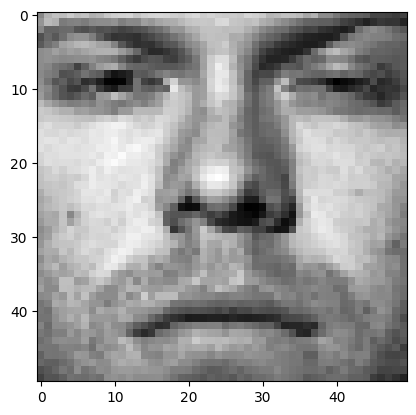

In [5]:
# Loading training data
train_labels, train_data = [], []
for line in open('./faces/train.txt'):
  im = imageio.imread(line.strip().split()[0])
  train_data.append(im.reshape(2500,))
  train_labels.append(line.strip().split()[1])
train_data, train_labels = np.array(train_data, dtype=float), np.array(train_labels, dtype=int)

print(train_data.shape, train_labels.shape)
plt.imshow(train_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

(100, 2500) (100,)


/var/folders/_6/vc6bwqjd62501rmy4hvwykhw0000gn/T/ipykernel_7055/303495666.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(line.strip().split()[0])


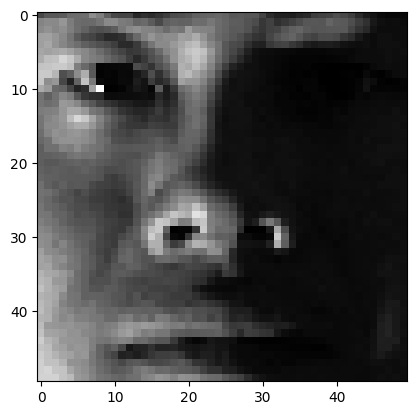

In [6]:
# Loading test data
test_labels, test_data = [], []
for line in open('./faces/test.txt'):
  im = imageio.imread(line.strip().split()[0])
  test_data.append(im.reshape(2500,))
  test_labels.append(line.strip().split()[1])
test_data, test_labels = np.array(test_data, dtype=float), np.array(test_labels, dtype=int)

print(test_data.shape, test_labels.shape)
plt.imshow(test_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

### **(c) Average Face**

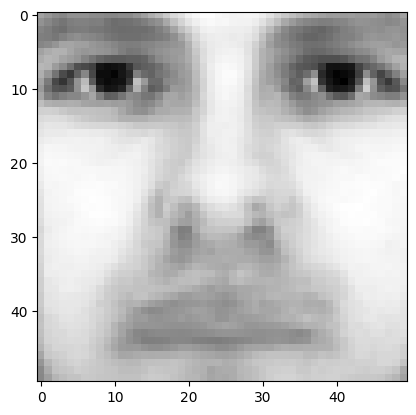

In [8]:
miu = train_data.sum(axis=0) / train_data.shape[0]
plt.imshow(miu.reshape(50,50), cmap = cm.Greys_r)
plt.savefig('img/miu.png')
plt.show()

### **(d) Mean Subtraction**

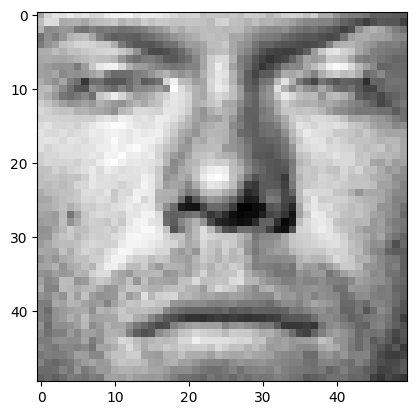

In [13]:
new_train = train_data - miu
plt.imshow(new_train[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.savefig('img/mean_sub_train.png')
plt.show()

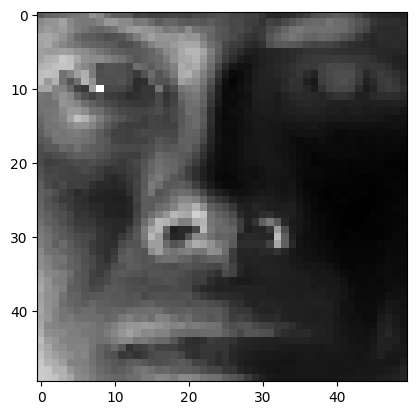

In [14]:
new_test = test_data - miu
plt.imshow(new_test[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.savefig('img/mean_sub_test.png')
plt.show()

### **(e) Eigenface**

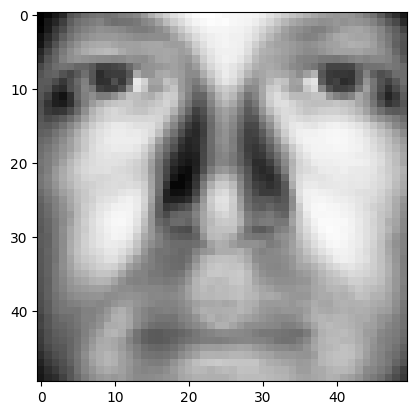

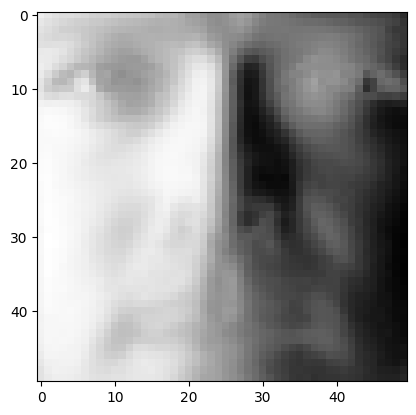

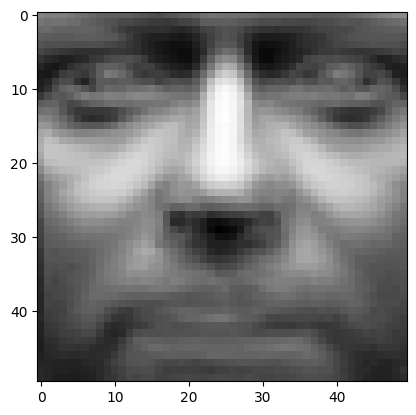

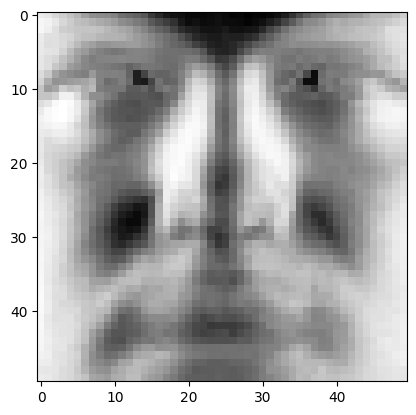

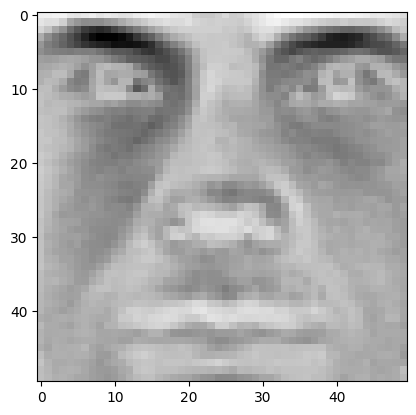

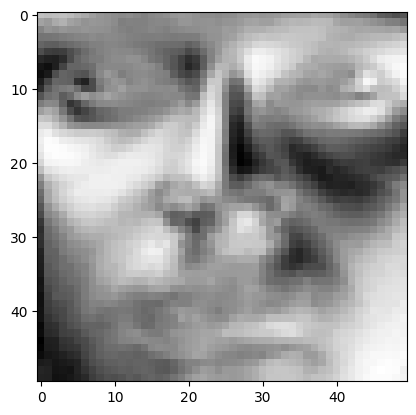

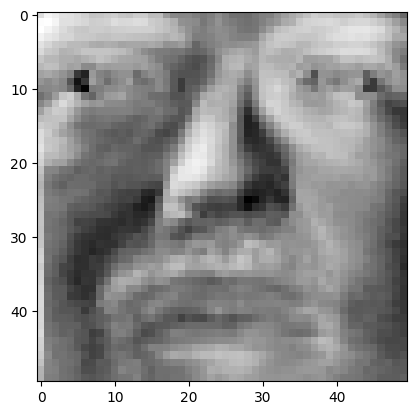

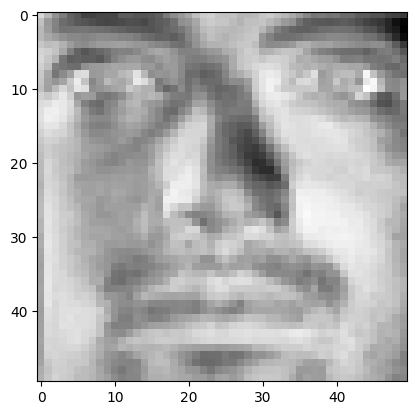

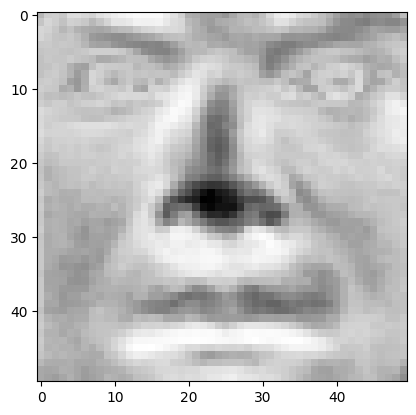

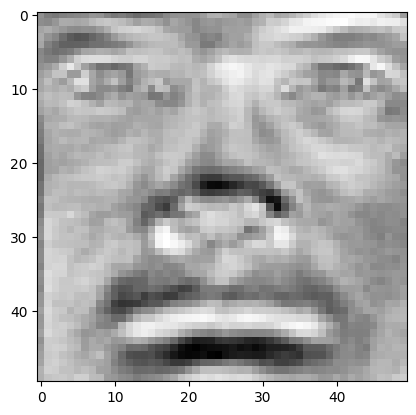

In [16]:
def compute_V_T(X):
  # np.linalg.eig(): the column eigenvectors[:, i] is 
  # the eigenvector corresponding to the eigenvalue eigenvalues[i]
  eigenvalues, eigenvectors = np.linalg.eig(np.dot(X.T, X))
  V_T = eigenvectors.T
  return V_T

train_V_T = compute_V_T(new_train)
for i in range(10):
  eigenface = np.real(train_V_T[i,:])  # np.real(): keep the real part of vectors with complex numbers in order to show plot
  plt.imshow(eigenface.reshape(50,50), cmap = cm.Greys_r)
  plt.savefig('img/eigenface_' + str(i) + '.png')
  plt.show()

### **(f) Eigenface Feature**

In [17]:
train_V_T = compute_V_T(new_train)
def getTrainF(r):
  transpose = train_V_T[:r, :].T
  f = np.dot(train_data, transpose)
  return np.real(f)

In [18]:
test_V_T = compute_V_T(new_test)
def getTestF(r):
  transpose = train_V_T[:r, :].T
  f = np.dot(test_data, transpose)
  return np.real(f)

### **(g) Face Recognition**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# extract training & test features
def extractFeatures(r):
  train_F = getTrainF(r)
  test_F = getTestF(r)
  return train_F, test_F

def logRegOvr(train_F, test_F):
  # train logistic regression model
  logRegOvr = LogisticRegression(multi_class="ovr", C=1e5, fit_intercept=True, solver='lbfgs', max_iter=1000)
  logRegOvr.fit(train_F, train_labels)
  # predict on test features
  pred_labels = logRegOvr.predict(test_F)
  # report accuracy
  acc = accuracy_score(test_labels, pred_labels)
  return acc

In [ ]:
import warnings
warnings.filterwarnings('ignore')

train_F, test_F = extractFeatures(10)
acc = logRegOvr(train_F, test_F)
print("When r = 10, the classification accuracy on test set is", acc)

When r = 10, the classification accuracy on test set is 0.8


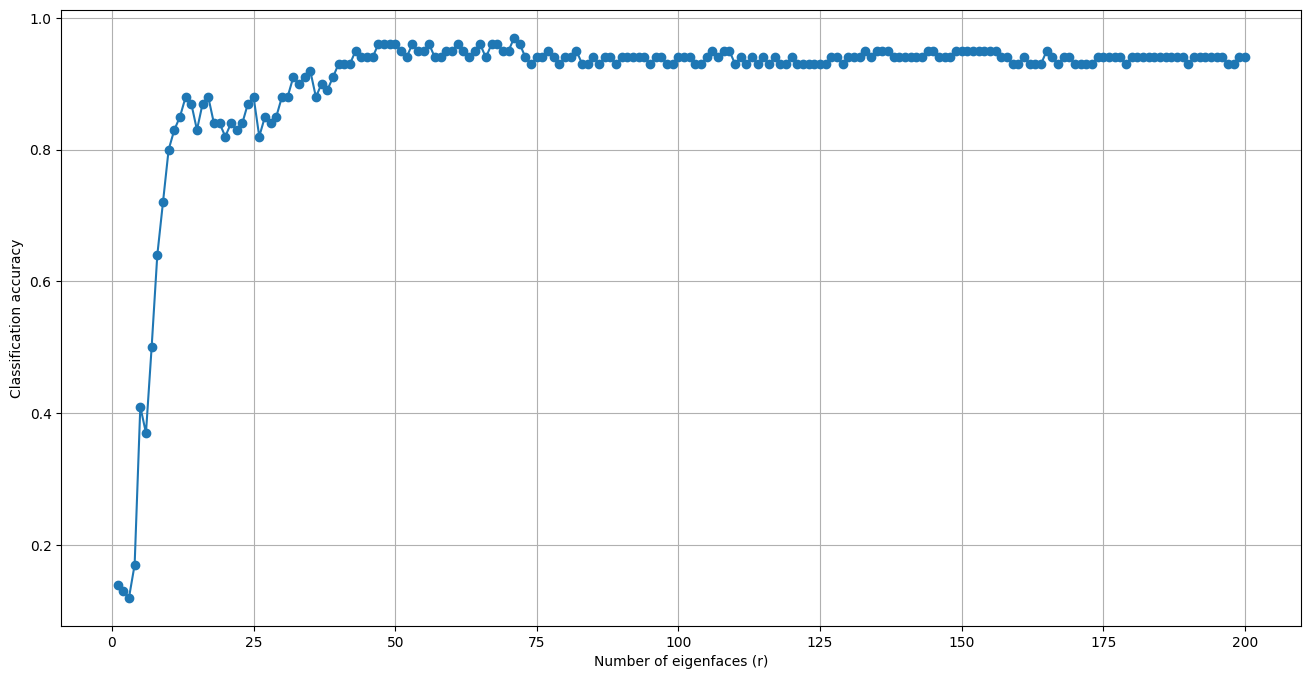

In [ ]:
all_acc = []
for r in range(1, 201):
  train_F, test_F = extractFeatures(r)
  all_acc.append(logRegOvr(train_F, test_F))

plt.figure(figsize=(16,8))
plt.plot(range(1,201), all_acc, marker = 'o')
plt.grid(True)
plt.xlabel("Number of eigenfaces (r)")
plt.ylabel("Classification accuracy")
plt.show()

### **(h) Low-Rank Data Loss**

In [ ]:
def compute_X_prime(X, V_T, r):
  # compute F given V_T & r:
  transpose = V_T[:r, :].T
  F = np.dot(X, transpose)
  # compute X_prime:
  X_prime = np.dot(F, V_T[:r, :])
  return X_prime

def compute_Frobenius(X, X_prime):
  diff = X - X_prime
  distance = np.sqrt(np.trace(np.dot(diff.T, diff)))
  return distance

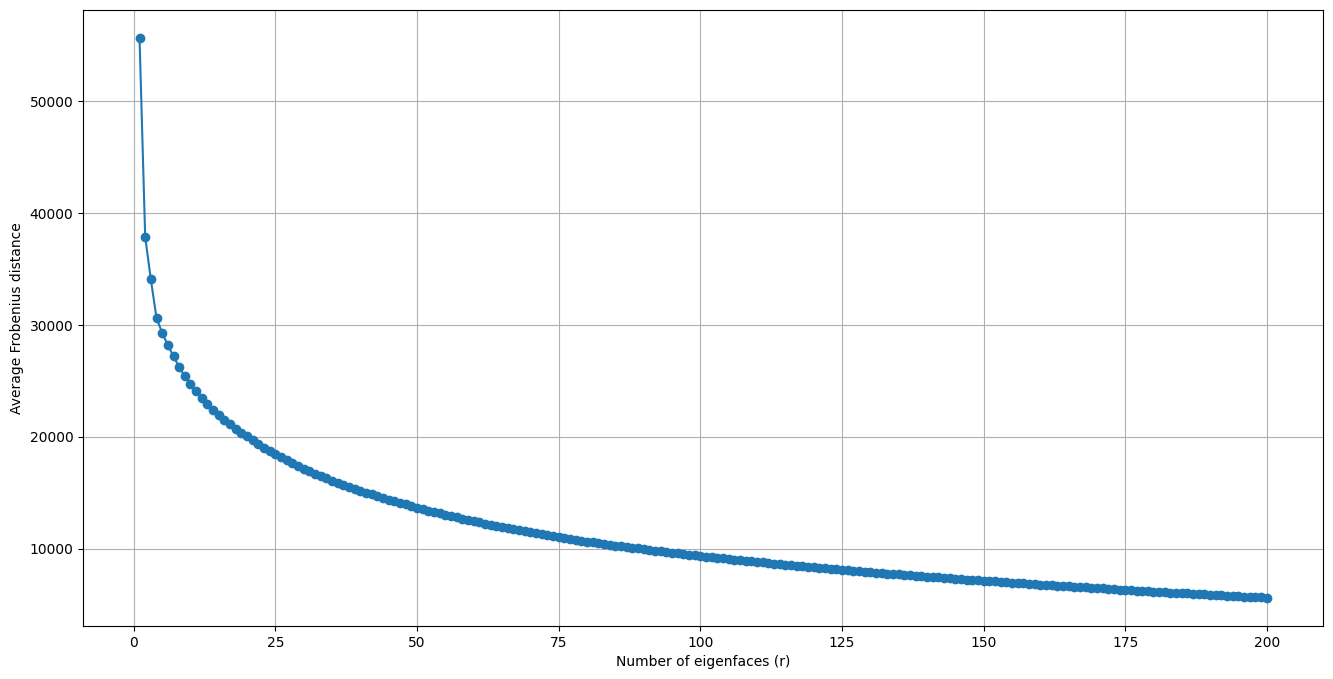

In [ ]:
all_dist = []
V_T = compute_V_T(train_data)

for r in range(1, 201):
  X_prime = compute_X_prime(train_data, V_T, r)
  dist = compute_Frobenius(train_data, X_prime)
  all_dist.append(dist)

plt.figure(figsize=(16,8))
plt.plot(range(1,201), all_dist, marker = 'o')
plt.grid(True)
plt.xlabel("Number of eigenfaces (r)")
plt.ylabel("Average Frobenius distance")
plt.show()